In [1]:
from segmenter_model_zoo.zoo import SegModel
from aicsimageio import AICSImage
from itkwidgets import view
import numpy as np
from aicsmlsegment.utils import background_sub, simple_norm, input_normalization
import pandas as pd
from pathlib import Path
from aicsimageio.writers import OmeTiffWriter

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 8]

## step 1: define a basic model object

In [2]:
my_model = SegModel()

In [3]:
# you can check all avaialable models:
my_model.list_all_trained_models()

DNA_mask_production
DNA_seed_production
CellMask_edge_production
CAAX_production
LMNB1_all_production
LMNB1_fill_production
LMNB1_seed_production
LF_DNA_mask
LF_DNA_mask_two_camera
LF_mem_edge
LF_mem_edge_two_camera
H2B_coarse


## step 2: load one pre-trained model

Suppose you want to load the "H2B_coarse". You can do `my_model.load_train('H2B_coarse')`. This will automatically download the pre-trained model from cloud storage and save a local copy at "./". You can also specify where to save the local copy by, for example, `my_model.load_train('H2B_coarse', {"local_path":"./all_models/"})`. If you already have downloaded the model before and saved it at "./all_models/", there won't be any download and the local model will be directly loaded.

In [4]:
my_model.load_train('H2B_coarse', {"local_path":"./"})
my_model.to_gpu('cuda:0')

model H2B_coarse is successfully loaded


## step 3: apply the H2B model on DNA dye image and H2B image

In [5]:
# read one image as numpy array
reader = AICSImage("C:/projects/demo/data/3500002666_100X_20190121-Scene-57_aligned_cropped-P56-D10.ome.tiff")
dna_img = reader.get_image_data("CZYX", C=[-1], S=0, T=0).astype(np.float32)
h2b_img = reader.get_image_data("CZYX", C=[1], S=0, T=0).astype(np.float32)

In [6]:
# apply the H2B model on H2B images
nuclear_mask_from_h2b = my_model.apply_on_single_zstack(h2b_img)

In [7]:
# apply the H2B model on dna dye images
nuclear_mask_from_dye = my_model.apply_on_single_zstack(dna_img)

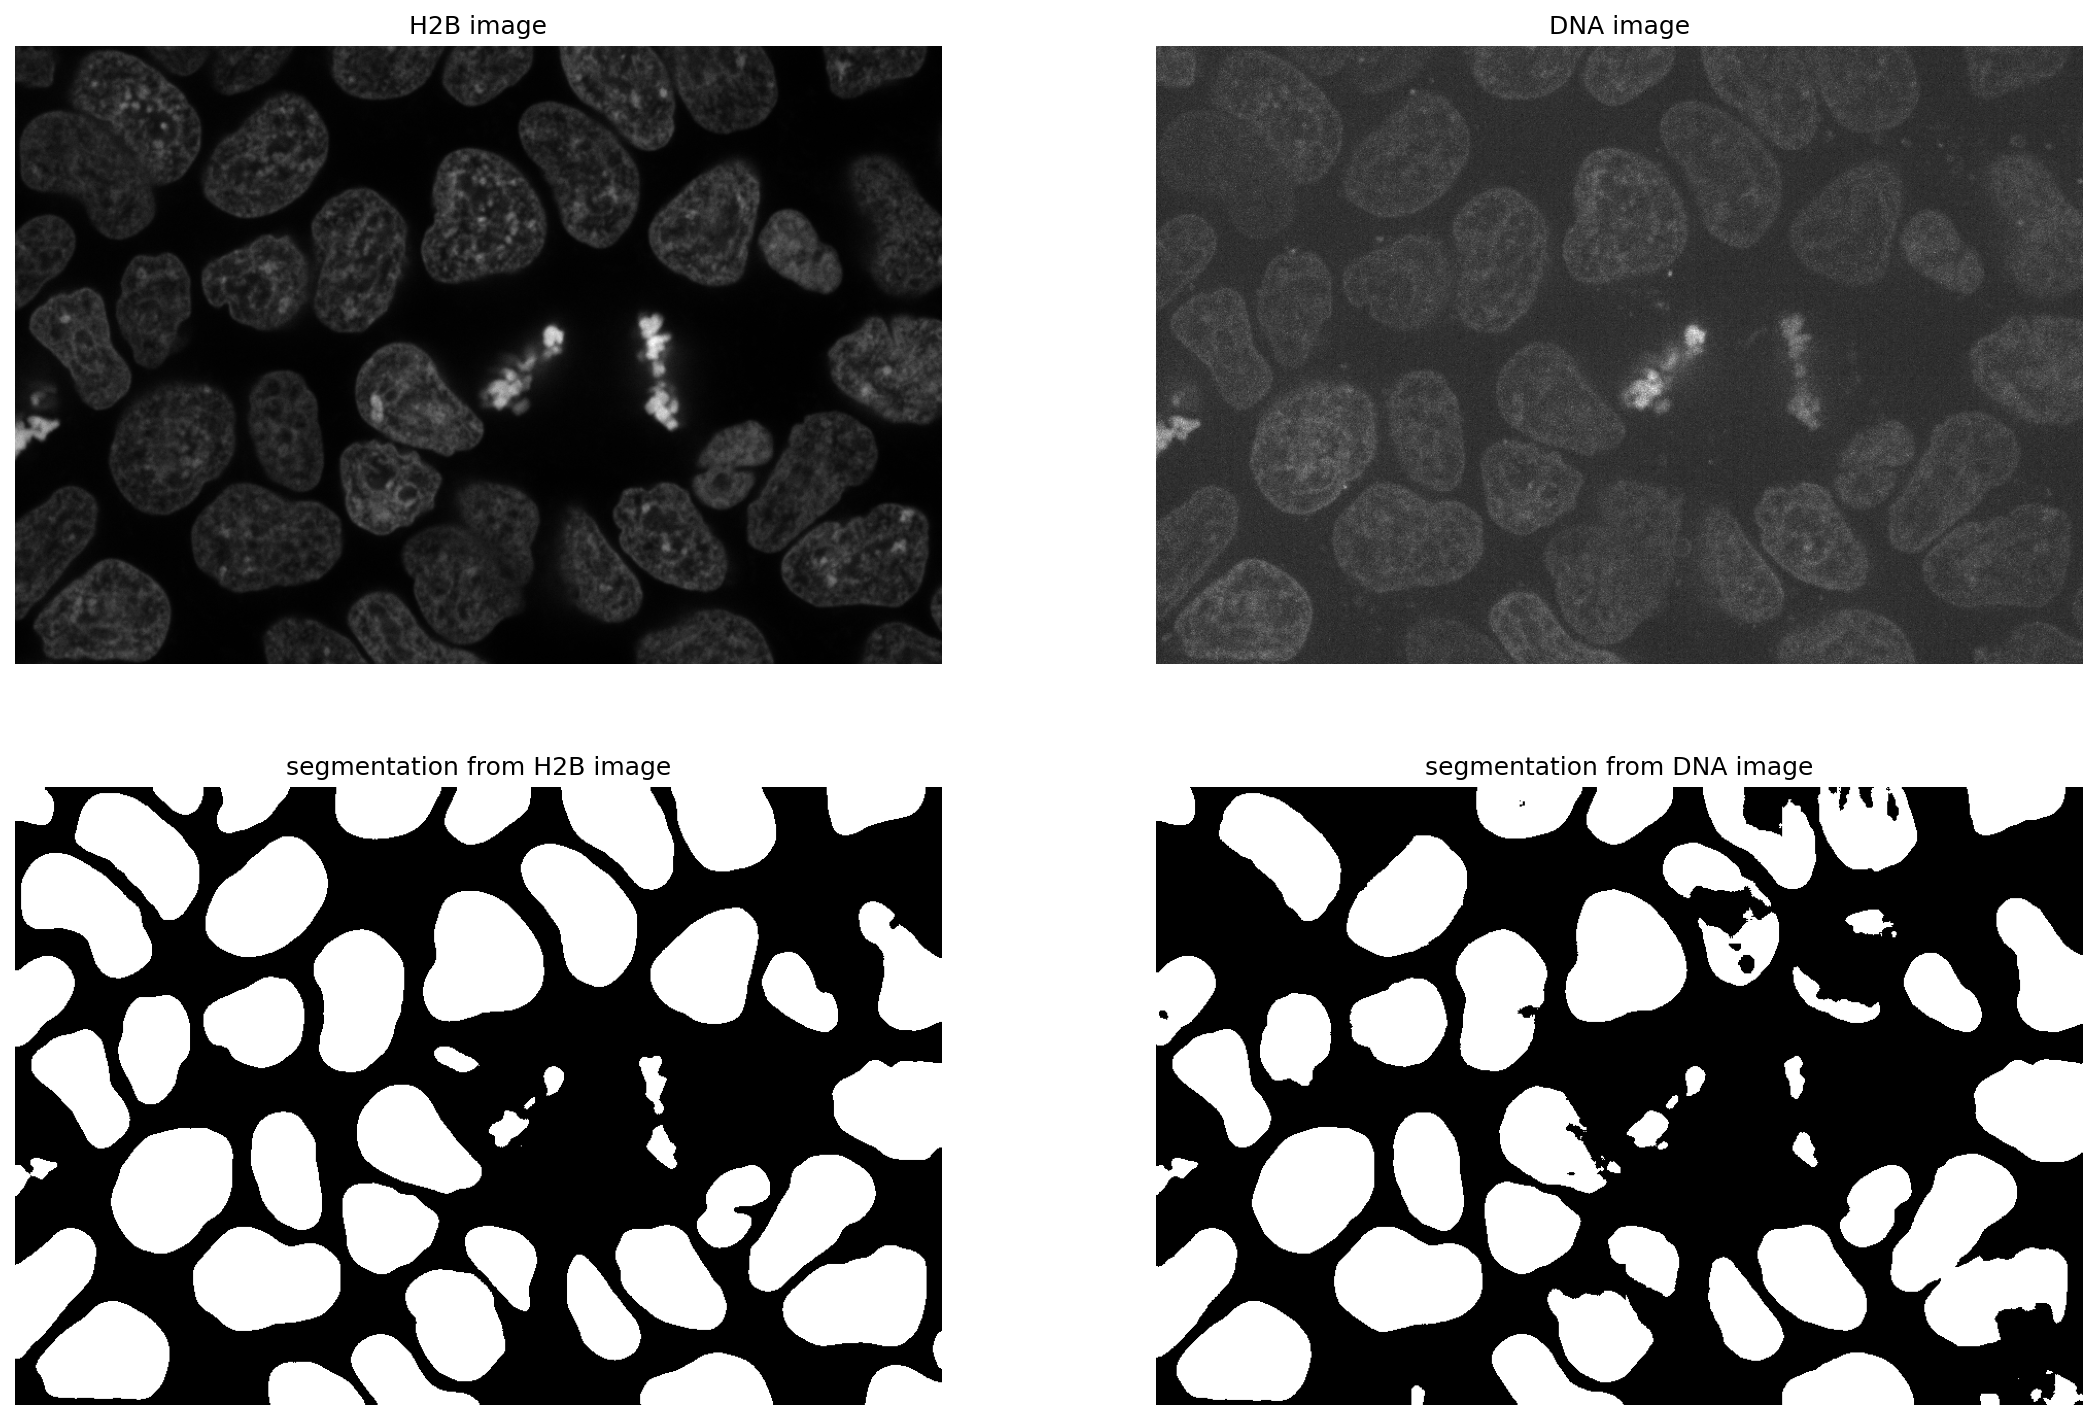

In [8]:
# compare the results
z = 22
fig, ax = plt.subplots(2, 2, figsize=(18,12), dpi=150, facecolor='w', edgecolor='k')

ax[0,0].axis('off')
ax[0,0].title.set_text('H2B image')
ax[0,0].imshow(h2b_img[0,z,:,:], cmap=plt.cm.gray)

ax[1,0].axis('off')
ax[1,0].title.set_text('segmentation from H2B image')
ax[1,0].imshow(nuclear_mask_from_h2b[z,:,:], cmap=plt.cm.gray)

ax[0,1].axis('off')
ax[0,1].title.set_text('DNA image')
ax[0,1].imshow(dna_img[0,z,:,:], cmap=plt.cm.gray)

ax[1,1].axis('off')
ax[1,1].title.set_text('segmentation from DNA image')
ax[1,1].imshow(nuclear_mask_from_dye[z,:,:], cmap=plt.cm.gray)

### Not quite working off-the-shelf for applying H2B model to DNA dye images

This is not a surprise. Theoretically, the H2B images and DNA dye images can be considered as two different "domains", and there is a "domain gap" between the models trained on. In general, to reduce the "domain gap" so that the model could work better off-the-shelf to get some good preliminary results, we could try match the resize the image to match the magnification and adjust the intensity to match the contrast. 

In our example, the images are just different channels of the same FOV. So we don't need to do anything about magnification. Otherwise, [skimage resize](https://scikit-image.org/docs/stable/auto_examples/transform/plot_rescale.html) can help do the job. Our data was from 100x ZEISS spinning disk images. The physical size of each voxel is 0.108 um x 0.108 um x 0.29 um (XYZ).

To adjust the intensity to match the contrast, we need to know what is the current model using for normalization:

normalization for H2B image:
https://github.com/AllenCell/segmenter_model_zoo/blob/main/segmenter_model_zoo/zoo.py#L98

The code shows that this model applies normalization recipe 18 from Segmenter:

https://github.com/AllenCell/aics-ml-segmentation/blob/main/aicsmlsegment/utils.py#L127

## Step 4: Check the effect of the current normalization 

In [9]:
# test the recipe 18 from Segmenter(https://github.com/AllenCell/aics-ml-segmentation/blob/main/aicsmlsegment/utils.py#L127)
h2b_image_backsub = background_sub(h2b_img.copy(),50)
h2b_image_normalized = simple_norm(h2b_image_backsub, 1.5, 10)

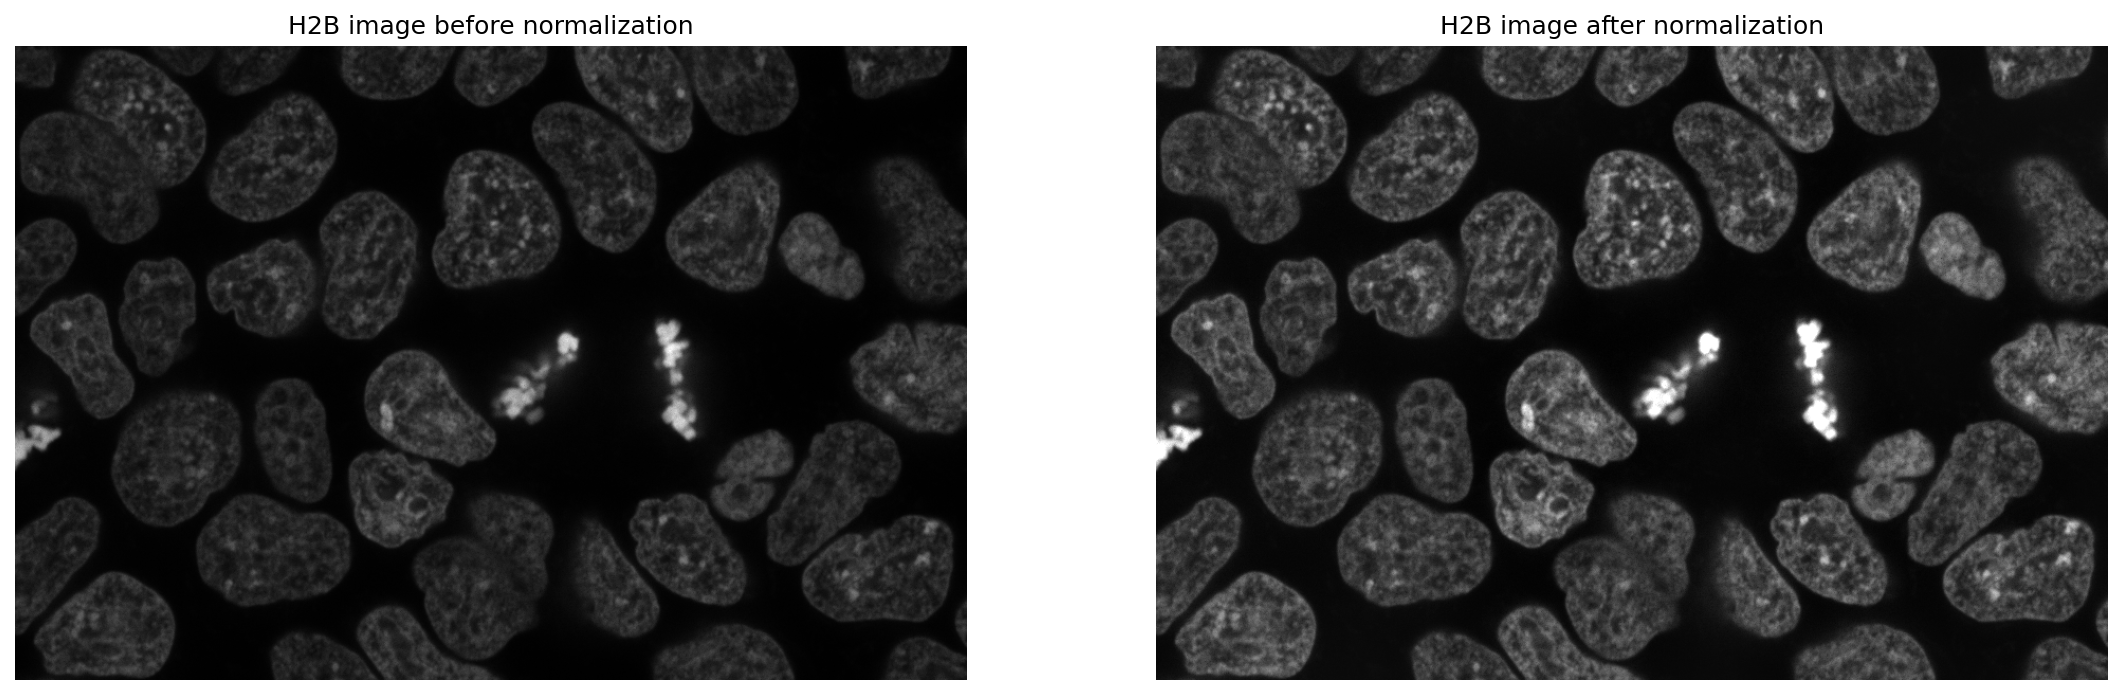

In [10]:
# compare the results to look at the effect
z = 22
fig, ax = plt.subplots(1, 2, figsize=(18,12), dpi=150, facecolor='w', edgecolor='k')

ax[0].axis('off')
ax[0].title.set_text('H2B image before normalization')
ax[0].imshow(h2b_img[0,z,:,:], cmap=plt.cm.gray)

ax[1].axis('off')
ax[1].title.set_text('H2B image after normalization')
ax[1].imshow(h2b_image_normalized[0, z,:,:], cmap=plt.cm.gray)

## Step 5: Adjust the normalization parameters to apply on the images in the "new domain" to match the current normalization effect

In [11]:
# background subtraction
dna_image_backsub = background_sub(dna_img.copy(),50)

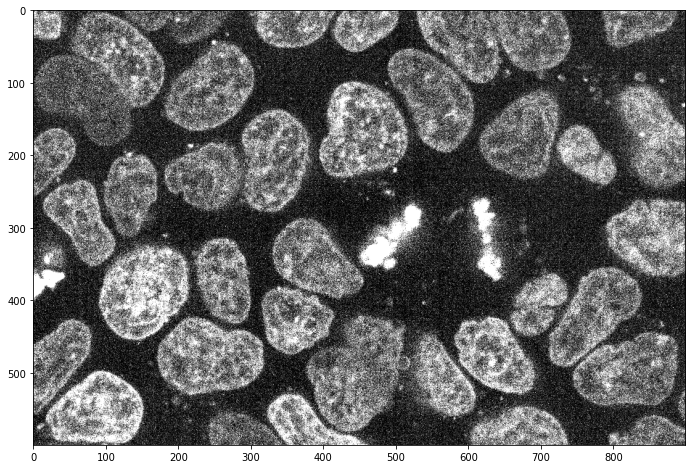

In [12]:
# try out different intensity normalization parameters and look at the results.
# keep adjusting until the results looking comparable to what we see on H2B images
z = 22
dna_image_normalized = simple_norm(dna_image_backsub.copy(), 1, 3)
plt.imshow(dna_image_normalized[0, z, :, :], cmap=plt.cm.gray)

## Step 6: Apply the model on the adjusted image

use `already_normalized=True` to bypass any normalizaiton the model does by default

In [13]:
nuclear_mask_from_dye_after_adjustment = my_model.apply_on_single_zstack(dna_image_normalized, already_normalized=True)

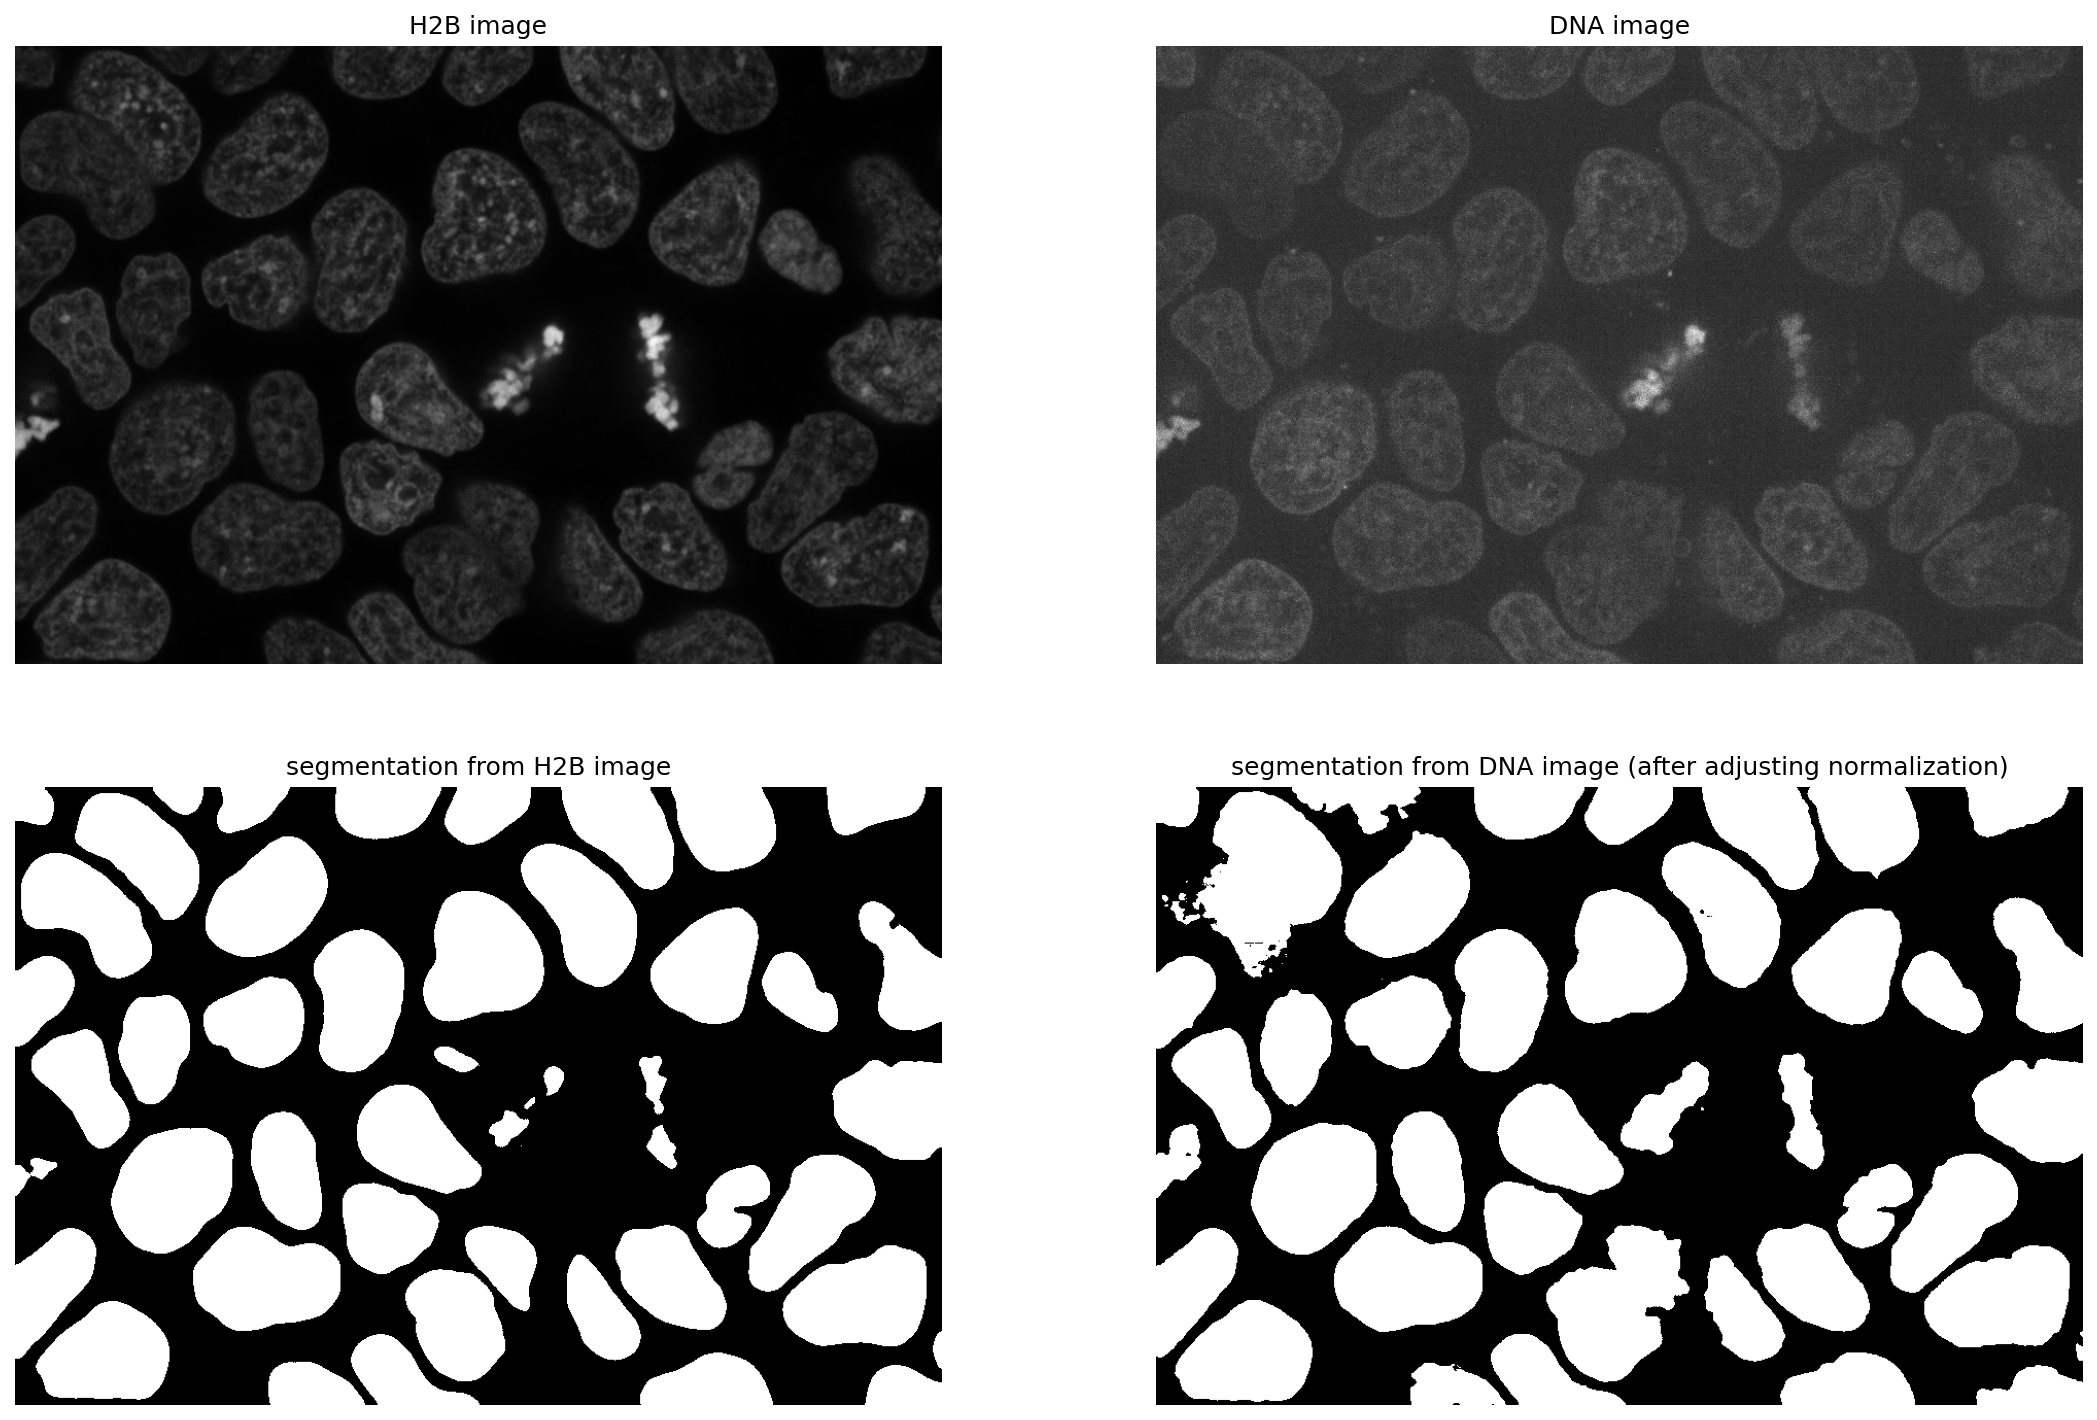

In [14]:
# compare the results
z = 22
fig, ax = plt.subplots(2, 2, figsize=(18,12), dpi=150, facecolor='w', edgecolor='k')

ax[0,0].axis('off')
ax[0,0].title.set_text('H2B image')
ax[0,0].imshow(h2b_img[0,z,:,:], cmap=plt.cm.gray)

ax[1,0].axis('off')
ax[1,0].title.set_text('segmentation from H2B image')
ax[1,0].imshow(nuclear_mask_from_h2b[z,:,:], cmap=plt.cm.gray)

ax[0,1].axis('off')
ax[0,1].title.set_text('DNA image')
ax[0,1].imshow(dna_img[0,z,:,:], cmap=plt.cm.gray)

ax[1,1].axis('off')
ax[1,1].title.set_text('segmentation from DNA image (after adjusting normalization)')
ax[1,1].imshow(nuclear_mask_from_dye_after_adjustment[z, :, :], cmap=plt.cm.gray)

### Note:

It is possible that the models won't work off-the-shelf. That's okay. The essential philosophy behind the iterative deep learning workflow is to start with some preliminary results and gradually improve the performance. So, try the two adjustments above about magnification and normalization in order to make the results as good as possible. Then, if you can find just a few cells where the segmentation is acceptable, then you can use the curation tool in our Segmenter (see [here](https://github.com/AllenInstitute/aics-ml-segmentation/blob/master/docs/bb2.md)) to collect a few good examples to finetune the model on your data. Then, when applying the new model on your data, the results may be better. You may need one more iteration of curation + training. 